##Untuk Reproducible

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)

np.random.seed(SEED)

tf.random.set_seed(SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'

##Memanggil data CIFAR-10

In [ ]:
import numpy as np
from tensorflow.keras import datasets
from sklearn.model_selection import train_test_split

(x_train_full, y_train_full), (x_test, y_test) = datasets.cifar10.load_data()

x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=SEED
)
#x_train = x_train.astype('float32') / 255.0
#x_val   = x_val.astype('float32') / 255.0
#x_test  = x_test.astype('float32') / 255.0

print("Train :", x_train.shape, y_train.shape)
print("Validation :", x_val.shape, y_val.shape)
print("Test :", x_test.shape, y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train : (40000, 32, 32, 3) (40000, 1)
Validation : (10000, 32, 32, 3) (10000, 1)
Test : (10000, 32, 32, 3) (10000, 1)


##Membuat data menjadi batch

In [ ]:
import tensorflow as tf

batch_size = 128

def make_dataset(x, y, training=False) :
  ds = tf.data.Dataset.from_tensor_slices((x, y))
  if training :
    ds = ds.shuffle(buffer_size=10000, seed=SEED)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

ds_train = make_dataset(x_train, y_train, training=True)
ds_val = make_dataset(x_val, y_val, training=False)
ds_test = make_dataset(x_test, y_test, training=False)

for batch_x, batch_y in ds_train.take(1) :
  print("Batch X shape: ", batch_x.shape)
  print("Batch y shape: ", batch_y.shape)

Batch X shape:  (128, 32, 32, 3)
Batch y shape:  (128, 1)


##Model dengan Keras

In [ ]:
import os
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

os.makedirs('checkpoints', exist_ok=True)

def build_cnn(conv_layers=3,
              filters=[96,192,192],
              kernel_size=(3,3),
              pooling='max',
              use_global_avg_pooling=True):
  assert conv_layers == len(filters)
  inp = layers.Input(shape=(32,32,3))
  x = inp
  for i in range(conv_layers) :
    x = layers.Conv2D(filters=filters[i],
                      kernel_size=kernel_size,
                      padding='same',
                      activation='relu')(x)
    if (i + 1) % 3 == 0:
      if pooling == 'max' :
        x = layers.MaxPooling2D(pool_size=(3,3),strides=2)(x)
      else :
        x = layers.AveragePooling2D(pool_size=(3,3),strides=2)(x)
  if use_global_avg_pooling :
    x = layers.Conv2D(10,(1,1),padding='valid')(x)
    x = layers.GlobalAveragePooling2D()(x)
  else :
    x = layers.Flatten()(x)
    x = layers.Dense(200,activation='relu',kernel_initializer=initializers.glorot_normal())(x)
    x = layers.Dense(100,activation='relu')(x)
    x = layers.Dense(10)(x)
  out = layers.Activation('softmax',dtype='float32')(x)

  model = models.Model(inputs=inp, outputs=out)
  model.compile(
      loss = 'sparse_categorical_crossentropy',
      optimizer = 'adam',
      metrics = []
  )
  return model

##Pelatihan model keras

In [ ]:
variant_name = "conv3_filters_96-192-192_kernel3_pool-max"
model = build_cnn(conv_layers=3,
              filters=[96,192,192],
              kernel_size=(3,3),
              pooling='max',
              use_global_avg_pooling=True)

csv_logger = CSVLogger(f'history_{variant_name}.csv')
chkpt = ModelCheckpoint(
    filepath=f'checkpoints/{variant_name}.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True
)

history = model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_val,
    callbacks=[csv_logger, chkpt]
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - loss: 5.2551 - val_loss: 1.5058
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - loss: 1.4869 - val_loss: 1.3203
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - loss: 1.3226 - val_loss: 1.2569
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - loss: 1.2073 - val_loss: 1.1449
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 1.1335 - val_loss: 1.0868
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 1.0644 - val_loss: 1.0504
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - loss: 1.0049 - val_loss: 1.0000
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - loss: 0.9379 - val_loss: 0.9992
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 0.9124 - val_loss: 0.9504
Epoch 10/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - loss: 0.8602 - val_loss: 0.8868
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - loss: 0.8040 - val_loss: 0.9801
Epoch 12/20
313/313 ━━━━━━━━━━

##Menghitung Macro F1 untuk base model

In [ ]:
from sklearn.metrics import f1_score

weights_path = f'checkpoints/{variant_name}.weights.h5'
model.load_weights(weights_path)

y_pred_probs = model.predict(ds_test)
y_pred = y_pred_probs.argmax(axis=-1)

y_true = y_test.flatten()

f1 = f1_score(y_true, y_pred, average='macro')
print(f"[{variant_name}] Keras macro-F1 on test set: {f1:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
[conv3_filters_96-192-192_kernel3_pool-max] Keras macro-F1 on test set: 0.7142


##Pengujian hyperparameter


=== Eksperimen conv_layers -> c2_f96-192_k3_max ===
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
conv_layers -> Macro-F1: 0.6665


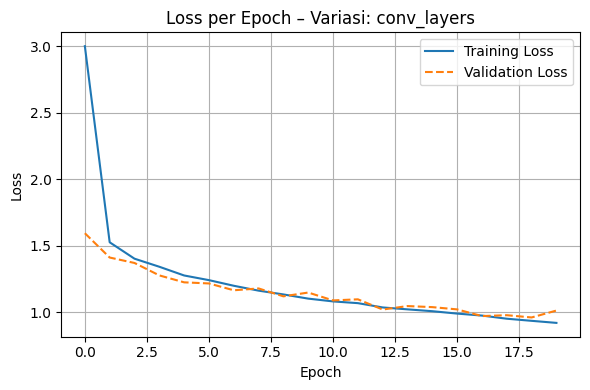


=== Eksperimen conv_layers -> c3_f96-192-192_k3_max ===
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
conv_layers -> Macro-F1: 0.7203


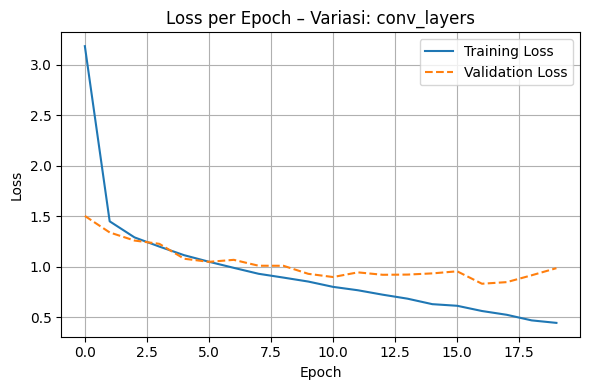


=== Eksperimen conv_layers -> c4_f96-192-192-192_k3_max ===
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
conv_layers -> Macro-F1: 0.7732


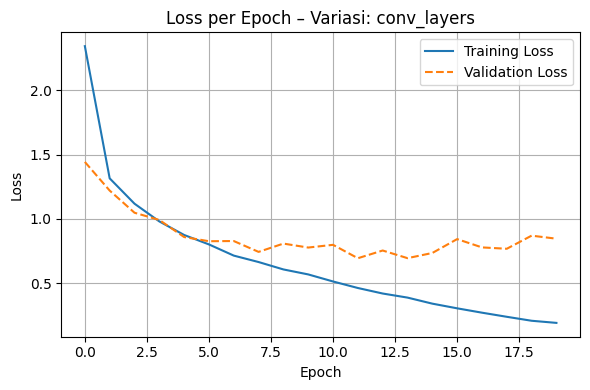


=== Eksperimen filters -> c3_f32-32-32_k3_max ===
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
filters -> Macro-F1: 0.6283


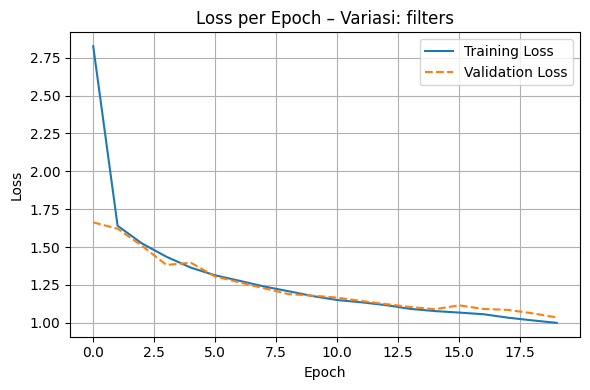


=== Eksperimen filters -> c3_f64-64-64_k3_max ===
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
filters -> Macro-F1: 0.6847


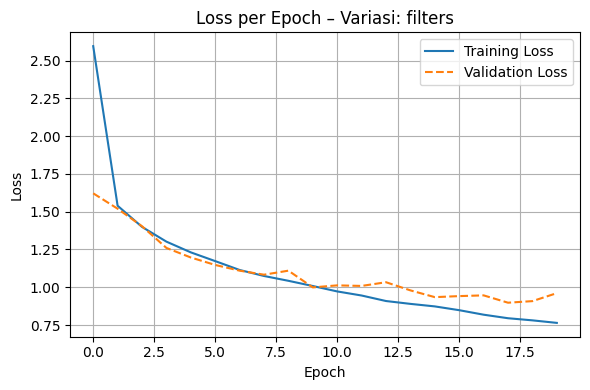


=== Eksperimen filters -> c3_f128-128-128_k3_max ===
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
filters -> Macro-F1: 0.6964


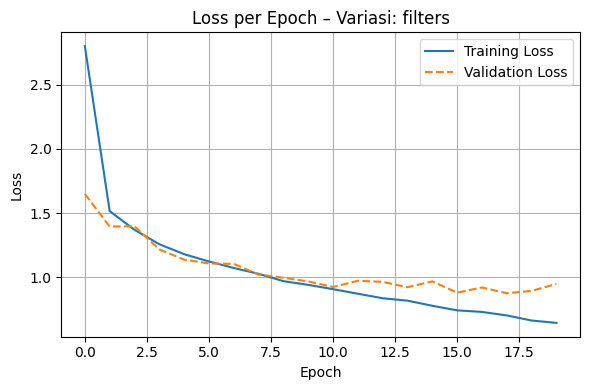


=== Eksperimen kernel_size -> c3_f96-192-192_k3_max ===
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
kernel_size -> Macro-F1: 0.7239


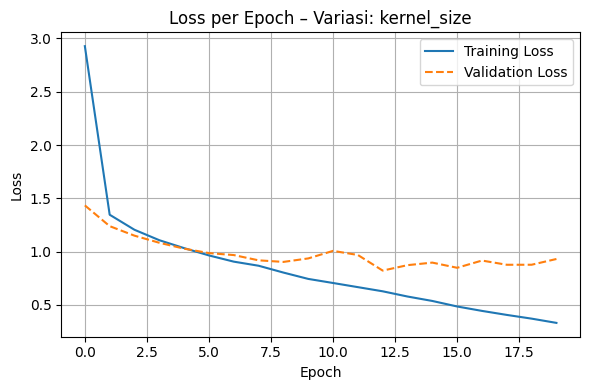


=== Eksperimen kernel_size -> c3_f96-192-192_k5_max ===
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
kernel_size -> Macro-F1: 0.6655


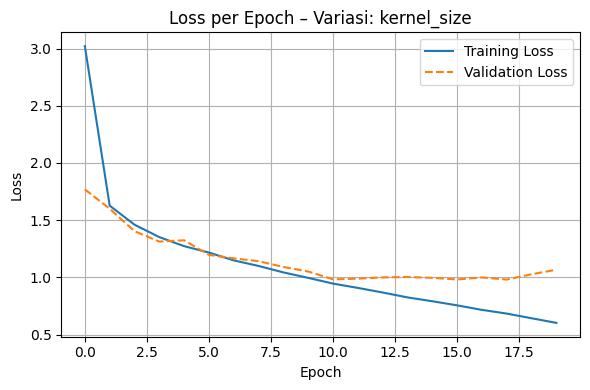


=== Eksperimen kernel_size -> c3_f96-192-192_k7_max ===
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step
kernel_size -> Macro-F1: 0.6359


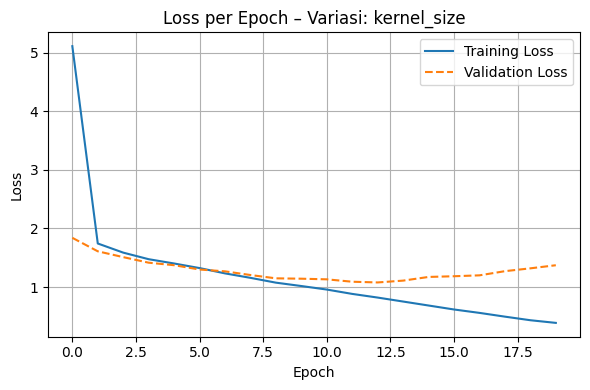


=== Eksperimen pooling -> c3_f96-192-192_k3_max ===
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
pooling -> Macro-F1: 0.7093


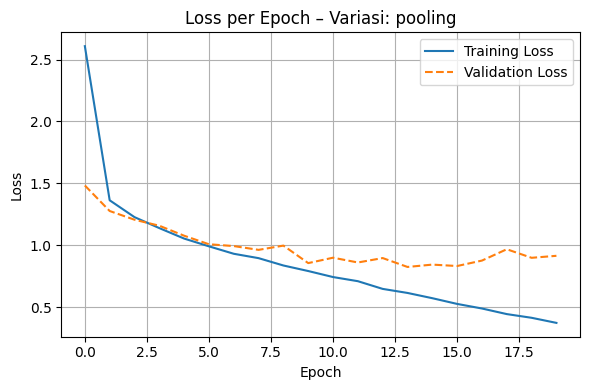


=== Eksperimen pooling -> c3_f96-192-192_k3_avg ===
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
pooling -> Macro-F1: 0.7171


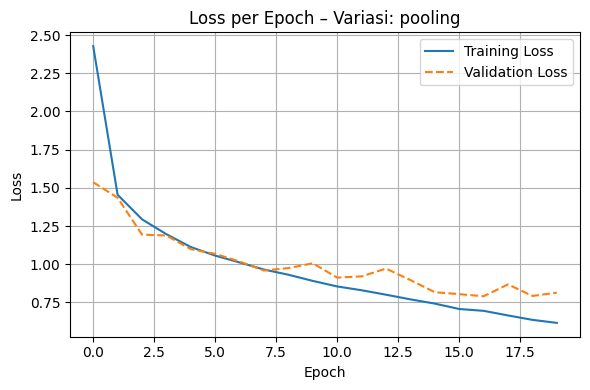


=== Ringkasan Eksperimen ===
                      variant         type  macro_f1
2   c4_f96-192-192-192_k3_max  conv_layers  0.773205
6       c3_f96-192-192_k3_max  kernel_size  0.723859
1       c3_f96-192-192_k3_max  conv_layers  0.720315
10      c3_f96-192-192_k3_avg      pooling  0.717090
9       c3_f96-192-192_k3_max      pooling  0.709337
5      c3_f128-128-128_k3_max      filters  0.696367
4         c3_f64-64-64_k3_max      filters  0.684670
0           c2_f96-192_k3_max  conv_layers  0.666513
7       c3_f96-192-192_k5_max  kernel_size  0.665467
8       c3_f96-192-192_k7_max  kernel_size  0.635923
3         c3_f32-32-32_k3_max      filters  0.628291


In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

baseline = {
    'conv_layers': 3,
    'filters': [96, 192, 192],
    'kernel_size': (3, 3),
    'pooling': 'max',
    'use_global_avg_pooling': True
}

variants = []
for cl in [2, 3, 4]:
    p = baseline.copy()
    p['conv_layers'] = cl
    variants.append(('conv_layers', p))
for f in [[32, 32, 32], [64, 64, 64], [128, 128, 128]]:
    p = baseline.copy()
    p['filters'] = f
    variants.append(('filters', p))
for k in [(3, 3), (5, 5), (7, 7)]:
    p = baseline.copy()
    p['kernel_size'] = k
    variants.append(('kernel_size', p))
for pool in ['max', 'avg']:
    p = baseline.copy()
    p['pooling'] = pool
    variants.append(('pooling', p))

assert len(variants) == 11, f"Expected 11 variants, got {len(variants)}"

results = []

for name, params in variants:
    flt = params['filters']
    cl = params['conv_layers']
    if len(flt) < cl:
        flt = flt + [flt[-1]] * (cl - len(flt))
    else:
        flt = flt[:cl]
    params['filters'] = flt

    vname = f"c{cl}_f{'-'.join(map(str, flt))}_k{params['kernel_size'][0]}_{params['pooling']}"
    print(f"\n=== Eksperimen {name} -> {vname} ===")

    model = build_cnn(
        conv_layers=params['conv_layers'],
        filters=params['filters'],
        kernel_size=params['kernel_size'],
        pooling=params['pooling'],
        use_global_avg_pooling=params['use_global_avg_pooling']
    )
    csv_logger = CSVLogger(f'history_{vname}.csv')
    chkpt = ModelCheckpoint(
        filepath=f'checkpoints/{vname}.weights.h5',
        save_weights_only=True,
        monitor='val_loss',
        save_best_only=True
    )
    history = model.fit(
        ds_train,
        epochs=20,
        validation_data=ds_val,
        callbacks=[csv_logger, chkpt],
        verbose=0
    )

    model.load_weights(f'checkpoints/{vname}.weights.h5')
    y_pred = model.predict(ds_test).argmax(axis=-1)
    y_true = y_test.flatten()
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{name} -> Macro-F1: {f1:.4f}")

    results.append({'variant': vname, 'type': name, 'macro_f1': f1})

    df = pd.DataFrame(history.history)
    plt.figure(figsize=(6, 4))
    plt.plot(df['loss'], label='Training Loss')
    plt.plot(df['val_loss'], label='Validation Loss', linestyle='--')
    plt.title(f'Loss per Epoch – Variasi: {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


df_res = pd.DataFrame(results)
df_res.to_csv('summary_results.csv', index=False)
print("\n=== Ringkasan Eksperimen ===")
print(df_res.sort_values(by='macro_f1', ascending=False))


##Model from scratch

In [ ]:
import numpy as np
import h5py

class Conv2D_Scratch:
    def __init__(self, W, b, padding='same', stride=1):
        self.W, self.b = W, b
        self.padding, self.stride = padding, stride

    def forward(self, x):
        batch, H, W, in_ch = x.shape
        kh, kw, _, out_ch = self.W.shape
        s = self.stride
        if self.padding == 'same':
            pad_h = (kh - 1) // 2
            pad_w = (kw - 1) // 2
            x = np.pad(x, ((0,0),(pad_h,pad_h),(pad_w,pad_w),(0,0)), mode='constant')
        H_out = (x.shape[1] - kh) // s + 1
        W_out = (x.shape[2] - kw) // s + 1
        out = np.zeros((batch, H_out, W_out, out_ch), dtype=np.float32)
        for n in range(batch):
            for i in range(H_out):
                for j in range(W_out):
                    for c in range(out_ch):
                        v0 = i * s
                        h0 = j * s
                        patch = x[n, v0:v0+kh, h0:h0+kw, :]
                        out[n, i, j, c] = np.sum(patch * self.W[..., c]) + self.b[c]
        return out

class Pooling_Scratch:
    def __init__(self, mode='max', pool_size=(2,2), stride=2):
        self.mode = mode
        self.ph, self.pw = pool_size
        self.stride = stride

    def forward(self, x):
        batch, H, W, C = x.shape
        ph, pw, s = self.ph, self.pw, self.stride
        H_out = (H - ph) // s + 1
        W_out = (W - pw) // s + 1
        out = np.zeros((batch, H_out, W_out, C), dtype=x.dtype)
        for n in range(batch):
            for i in range(H_out):
                for j in range(W_out):
                    v0 = i * s
                    h0 = j * s
                    patch = x[n, v0:v0+ph, h0:h0+pw, :]
                    if self.mode == 'max':
                        out[n, i, j, :] = patch.reshape(-1, C).max(axis=0)
                    else:
                        out[n, i, j, :] = patch.reshape(-1, C).mean(axis=0)
        return out

class Flatten_Scratch:
    def forward(self, x):
        return x.reshape(x.shape[0], -1)

class GlobalAvgPool2D_Scratch:
    def forward(self, x):
        return x.mean(axis=(1,2))

class Dense_Scratch:
    def __init__(self, W, b):
        self.W, self.b = W, b
    def forward(self, x):
        return x.dot(self.W) + self.b

class ReLU_Scratch:
    def forward(self, x):
        return np.maximum(0, x)

class Softmax_Scratch:
    def forward(self, x):
        e = np.exp(x - x.max(axis=1, keepdims=True))
        return e / e.sum(axis=1, keepdims=True)

class CNNFromScratch:
    def __init__(self, h5_filepath, config):
        self.layers = []
        f = h5py.File(h5_filepath, 'r')
        layers_group = f['layers']
        # conv blocks
        for i in range(config['conv_layers']):
            layer_name = 'conv2d' if i == 0 else f'conv2d_{i}'
            vars_group = layers_group[layer_name]['vars']
            W = vars_group['0'][:]
            b = vars_group['1'][:]
            self.layers.append(Conv2D_Scratch(W, b, padding='same', stride=1))
            self.layers.append(ReLU_Scratch())
            if (i+1) % 3 == 0:
                self.layers.append(Pooling_Scratch(mode=config['pooling'], pool_size=(3,3), stride=2))
        # output head
        if config['use_global_avg_pooling']:
            out_name = f'conv2d_{config["conv_layers"]}'
            vars_group = layers_group[out_name]['vars']
            Wf = vars_group['0'][:]
            bf = vars_group['1'][:]
            self.layers.append(Conv2D_Scratch(Wf, bf, padding='valid', stride=1))
            self.layers.append(GlobalAvgPool2D_Scratch())
            self.layers.append(Softmax_Scratch())
        else:
            self.layers.append(Flatten_Scratch())
            # dense layers sequential
            dense_names = [name for name in layers_group if name.startswith('dense')]
            for dn in dense_names:
                vars_group = layers_group[dn]['vars']
                Wd = vars_group['0'][:]
                bd = vars_group['1'][:]
                self.layers.append(Dense_Scratch(Wd, bd))
                self.layers.append(ReLU_Scratch())
            self.layers.append(Softmax_Scratch())
        f.close()

    def forward(self, x):
        out = x.astype(np.float32)
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def forward_debug(self, x):
      out = x.astype(np.float32)
      activations = []
      for layer in self.layers:
          out = layer.forward(out)
          activations.append(out)
      return activations



##Cek struktur file weights.h5

In [ ]:
import h5py
variant_name = "conv3_filters_96-192-192_kernel3_pool-max"
weights_path = f'checkpoints/{variant_name}.weights.h5'
with h5py.File(weights_path, 'r') as f:
    print("Root keys:", list(f.keys()))
    if 'model_weights' in f:
        print("model_weights keys:", list(f['model_weights'].keys()))
    def print_name(name):
        print(name)
    print("\nFull hierarchy:")
    f.visit(print_name)


Root keys: ['layers', 'optimizer', 'vars']

Full hierarchy:
layers
layers/activation
layers/activation/vars
layers/conv2d
layers/conv2d/vars
layers/conv2d/vars/0
layers/conv2d/vars/1
layers/conv2d_1
layers/conv2d_1/vars
layers/conv2d_1/vars/0
layers/conv2d_1/vars/1
layers/conv2d_2
layers/conv2d_2/vars
layers/conv2d_2/vars/0
layers/conv2d_2/vars/1
layers/conv2d_3
layers/conv2d_3/vars
layers/conv2d_3/vars/0
layers/conv2d_3/vars/1
layers/global_average_pooling2d
layers/global_average_pooling2d/vars
layers/input_layer
layers/input_layer/vars
layers/max_pooling2d
layers/max_pooling2d/vars
optimizer
optimizer/vars
optimizer/vars/0
optimizer/vars/1
optimizer/vars/10
optimizer/vars/11
optimizer/vars/12
optimizer/vars/13
optimizer/vars/14
optimizer/vars/15
optimizer/vars/16
optimizer/vars/17
optimizer/vars/2
optimizer/vars/3
optimizer/vars/4
optimizer/vars/5
optimizer/vars/6
optimizer/vars/7
optimizer/vars/8
optimizer/vars/9
vars


##Cek kesamaan hasil prediksi model keras dan model from scratch

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
for x_batch, y_batch in ds_test.take(1):
    x_batch_np = x_batch.numpy()  # shape (16,32,32,3)
    break
variant_name = "conv3_filters_96-192-192_kernel3_pool-max"
keras_model = build_cnn(
    conv_layers=3,
    filters=[96,192,192],
    kernel_size=(3,3),
    pooling='max',
    use_global_avg_pooling=True
)
keras_model.load_weights(f'checkpoints/{variant_name}.weights.h5')
y_keras = keras_model.predict(x_batch_np).argmax(axis=-1)

config = {
    'conv_layers': 3,
    'filters': [96,192,192],
    'kernel_size': (3,3),
    'pooling': 'max',
    'use_global_avg_pooling': True
}
scratch = CNNFromScratch(f'checkpoints/{variant_name}.weights.h5', config)
y_scratch_probs = scratch.forward(x_batch_np)
y_scratch = y_scratch_probs.argmax(axis=-1)
print("Keras preds:   ", y_keras)
print("Scratch preds: ", y_scratch)
print("Same?          ", np.all(y_keras == y_scratch))

matches = (y_keras == y_scratch)
print(f"Batch accuracy match: {matches.mean():.4f} ({matches.sum()}/{len(matches)})")

mismatch_idx = np.where(~matches)[0]
print("Example mismatches at positions:", mismatch_idx[:10])

f1_batch = f1_score(y_batch.numpy().flatten(), y_scratch, average='macro')
print(f"Batch macro-F1: {f1_batch:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Keras preds:    [3 8 8 8 6 6 1 4 3 1 0 9 5 7 9 8 5 7 8 6 7 0 8 9 4 5 3 0 9 6 6 5 4 3 9 8 4
 1 9 5 4 6 3 6 0 9 3 9 7 4 9 8 7 3 8 8 5 3 5 3 7 3 6 3 6 2 1 2 3 9 2 4 8 8
 0 2 9 5 3 8 8 1 1 7 2 2 2 4 8 9 0 3 8 6 4 6 6 2 0 7 4 2 5 3 1 1 8 6 8 7 4
 2 2 4 1 0 0 9 2 5 8 3 1 2 8 1 8 3]
Scratch preds:  [3 8 8 8 6 6 1 4 3 1 0 9 5 7 9 8 5 7 8 6 7 0 8 9 4 5 3 0 9 6 6 5 4 3 9 8 4
 1 9 5 4 6 3 6 0 9 3 9 7 4 9 8 7 3 8 8 5 3 5 3 7 3 6 3 6 2 1 2 3 9 2 4 8 8
 0 2 9 5 3 8 8 1 1 7 2 2 2 4 8 9 0 3 8 6 4 6 6 2 0 7 4 2 5 3 1 1 8 6 8 7 4
 2 2 4 1 0 0 9 2 5 8 3 1 2 8 1 8 3]
Same?           True
Batch accuracy match: 1.0000 (128/128)
Example mismatches at positions: []
Batch macro-F1: 0.7414


Kode di bawah tidak sanggup dijalankan dengan GPU T4 di Google Colab karena komputasi yang terlalu berat untuk keseluruhan data test menggunakan forward propagation from scratch.

In [ ]:
from tqdm import tqdm
from sklearn.metrics import f1_score

all_preds = []
all_labels = []
variant_name = "conv3_filters_96-192-192_kernel3_pool-max"
config = {
    'conv_layers': 3,
    'filters': [96,192,192],
    'kernel_size': (3,3),
    'pooling': 'max',
    'use_global_avg_pooling': True
}
scratch = CNNFromScratch(f'checkpoints/{variant_name}.weights.h5', config)

for x_batch, y_batch in tqdm(ds_test, desc="Scratch inference"):
    x_np = x_batch.numpy()           # (batch,32,32,3)
    probs = scratch.forward(x_np)    # (batch,10)
    preds = probs.argmax(axis=1)     # (batch,)
    all_preds.append(preds)
    all_labels.append(y_batch.numpy().flatten())

y_scratch_full = np.concatenate(all_preds)
y_true_full    = np.concatenate(all_labels)

f1_scratch = f1_score(y_true_full, y_scratch_full, average='macro')
print("Scratch macro-F1 on full test set:", f1_scratch)

In [ ]:
y_scratch_full = scratch.forward(x_test.astype('float32')).argmax(axis=-1)
f1_scratch = f1_score(y_test.flatten(), y_scratch_full, average='macro')
print("Scratch macro-F1:", f1_scratch)